In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Utility Functions

In [2]:
def get_root(tree):
    nodes = set(tree.keys())
    for node in tree:
        for child in tree[node]:
            child=str(child)
            try:
                nodes.remove(child)
            except Exception as e:
                print("Exception: " + str(e))
                #print("Already removed" + str(child))

    if(len(nodes) > 1):
        print("Error: more than one node remaining in parent list")
        return -1 
    return nodes.pop()

In [3]:
def get_parent(clone, tree):
    for key in tree:
        if int(clone) in tree[key]:
            return key 
    return -1

## Begin

Define the inputs here;
* `N` = size of grid (NxN)
* `phylogeny` = phylogenetic tree

These are global variables.

Assumptions:
* phylogeny starts at 1; 0 is reserved for normal 

In [4]:
# necessary inputs 
NORMAL_PURITY_THRESHOLD=.20
N = 10
phylogeny = {
    "1": [2, 3],
    "2": [],
    "3": [4, 5],
    "4": [],
    "5": []
}

In [5]:
root = get_root(phylogeny)
num_clones = len(phylogeny.keys())

(array([ 4.,  8., 13., 13., 11., 15., 18.,  7.,  3.,  8.]),
 array([0.22668705, 0.27609067, 0.32549429, 0.3748979 , 0.42430152,
        0.47370514, 0.52310876, 0.57251237, 0.62191599, 0.67131961,
        0.72072322]),
 <a list of 10 Patch objects>)

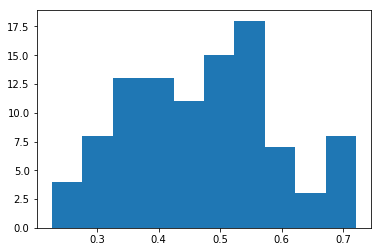

In [6]:
## Dirichlet Distribution Analysis 
d=[]
for i in range(0,100):
     d.append(np.random.dirichlet([1,8,8]))
d=np.asarray(d)
plt.hist(d[:,2])

### Initialize Matrix

In [7]:
matrix = [[{'0':0.0} for x in range(N)] for y in range(N)]

### Traverse through clones and place them
Assumptions:
* Root is the first in phylogeny.keys()

In [8]:
def get_starting_pos(clone, positions):
    '''
    Input: 
        - clone 
        - positions (dictionary of clones and their current positions on the matrix)
    Output: 
        a pair that represents a spot on the matrix 
        - If root, we will start at the center (N/2, N/2)
        - Otherwise, we will randomly pick a place that the clone's parent is at
    '''
    if clone == root:
        return (int(N/2),int(N/2))
    else:
        parent=get_parent(clone,phylogeny)
        arr=np.arange(len(positions[parent]))
        rand_idx=np.random.choice(arr)
        return positions[parent][rand_idx]

In [9]:
def within_bounds(coordinates):
    '''
    Input:
        - coordinates (x,y)
    Output:
        - boolean value indicating whether coordinates are within grid bounds
    '''
    x = coordinates[0] 
    y = coordinates[1]
    if x >= 0 and x < N and y >= 0 and y < N:
        return True
    return False

In [10]:
def get_position_probability(coordinate, clone, grid):
    '''
    Input:
        - coordinate to move to 
        - clone 
    Output:
        - probability of clone moving to specified position 
        Rules:
            base probability starts at 1
            +1 if space is empty
            +1 for each neighbor that has clone 
    '''
    
    prob=1.0
    x=coordinate[0]
    y=coordinate[1]
    
    if not within_bounds((x,y)):
        return 0.0
    
    if len(grid[x][y]) == 1:
        prob+=1
    # for each direction, add one IF there is a tumor 
    
    # up
    if within_bounds((x, y+1)) and len(grid[x][y+1]) > 1:
        prob+=1
    # down
    elif within_bounds((x, y-1)) and len(grid[x][y-1]) > 1:
        prob+=1
    # left 
    elif within_bounds((x-1, y)) and len(grid[x-1][y]) > 1:
        prob+=1
    # right 
    elif within_bounds((x+1, y)) and len(grid[x+1][y]) > 1:
        prob+=1
    
    return prob**2

In [11]:
# UP
# DOWN
# LEFT
# RIGHT

def move_clone(coordinates, clone, grid):
    '''
    Input:
        - coordinate (x,y) of current position
        - clone 
        - current grid status
    Output:
        - coordinate (x,y) of position to move to
    '''
    x=coordinates[0]
    y=coordinates[1]
    #moves_idx=['up','down','left','right']
    moves_idx=[0,1,2,3]
    moves=[(x, y+1),(x, y-1),(x-1, y),(x+1, y)]
    probs=[0.25,0.25,0.25,0.25]
    moved=False
    
    for idx, i in enumerate(moves):
        probs[idx]=get_position_probability(i,clone,grid)
    probs=probs/(np.sum(probs))
    draw=np.random.choice(moves_idx, 1, p=probs)[0]
    return moves[draw]
#     while not moved:
#         move=np.random.choice(moves)
#         #print(move)
#         if move == 'up' and within_bounds((x, y+1)):
#             return (x, y+1)
#         elif move == 'down' and within_bounds((x, y-1)):
#             return (x, y-1)
#         elif move == 'left' and within_bounds((x-1, y)):
#             return (x-1, y)
#         elif move == 'right' and within_bounds((x+1, y)):
#             return (x+1, y)

(array([ 3.,  9., 17., 25., 17., 21.,  1.,  4.,  2.,  1.]),
 array([-2.09763932, -1.56290027, -1.02816123, -0.49342218,  0.04131687,
         0.57605592,  1.11079496,  1.64553401,  2.18027306,  2.71501211,
         3.24975116]),
 <a list of 10 Patch objects>)

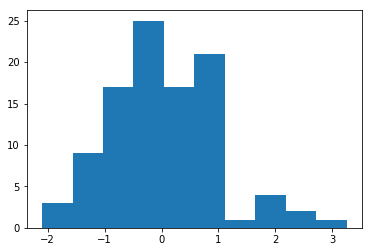

In [12]:
## Normal Distributions Analysis
test=[]
for i in range(0, 100):
    test.append(np.random.normal(0,1))
len([i for i in test if i < -2]) 
plt.hist(test)

In [13]:
def get_grid(phylogeny, N):
    # alphas[0] will be the normal; purity should be < NORMAL_PURITY_THRESHOLD (0.2)
    # TODO ! ! ! ! make alphas scale with size of phylogeny AND PURITY threshold 
    alphas=[1,8,7,6,9,6,8]
    grid = [[{'0':0.0} for x in range(N)] for y in range(N)]
    positions={}
    for clone in phylogeny.keys():

        positions[clone]=[]
        # initialize to start in middle
        cur=get_starting_pos(clone, positions)
        # probability of moving
        while np.random.normal(0,1) > -2:
            x=cur[0]
            y=cur[1]
            
            # add position to clone position dictionary
            positions[clone].append(cur)
            
            # generate frequency from dirichlet
            grid[x][y][clone] = 0.0
            freqs = np.random.dirichlet(alphas[:len(grid[x][y].keys())])
            #freqs=np.around(np.array(freqs),4)
            while freqs[0] > NORMAL_PURITY_THRESHOLD:
                freqs = np.random.dirichlet(alphas[:len(grid[x][y].keys())])
            for idx,key in enumerate(grid[x][y]):
                grid[x][y][key] = freqs[idx]

            # move 
            cur = move_clone(cur,clone,grid)
    return grid

## Visualize matrix

In [14]:
from matplotlib import colors
import matplotlib.patches as mpatches

In [15]:
def stringify(arr):
    num=""
    for i in arr:
        num+=i
    return int(num)

In [16]:
def plot_grid(matrix):
    image_grid = [[stringify(matrix[x][y].keys()) for x in range(N)] for y in range(N)]
    r = lambda: np.random.randint(0,255)
    brewer=['#a6cee3','#1f78b4','#b2df8a','#33a02c',
            '#fb9a99','#e31a1c','#fdbf6f','#ff7f00',
            '#cab2d6','#6a3d9a','#ffff99','#b15928',
            '#000000','#ffed6f','#aaaaaa','#bbbbbb',
            '#8dd3c7','#ffffb3','#bebada','#fb8072',
            '#80b1d3','#fdb462','#b3de69','#fccde5',
            '#d9d9d9','#bc80bd','#ccebc5','#ffed6f']
    c=[]
    for i in range(len(np.unique(image_grid))):
#         r = lambda: np.random.randint(0,255)/255
#         c.append((r(),r(),r()))
        c.append(brewer[i])

    #cmap = colors.ListedColormap(['black','blue','red','green','yellow','white'])
    cmap = colors.ListedColormap(c)
    bounds = np.unique(image_grid)-.01
    norm = colors.BoundaryNorm(bounds, cmap.N)
    values=np.unique(image_grid)
    patches = [mpatches.Patch(color=c[i], label="Clones {l}".format(l=values[i]) ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.title("Simulation Grid")
    plt.imshow(image_grid,cmap=cmap,norm=norm)
    
    return image_grid

In [17]:
def pretty_print(matrix):
    for i in matrix:
        print(i)

## The full pipeline

Define the inputs here;
* `N` = size of grid (NxN)
* `phylogeny` = phylogenetic tree

Assumptions:
* phylogeny starts at 1; 0 is reserved for normal 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 34, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 34, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 345, 3, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 123, 23, 235, 2, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 5, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0,

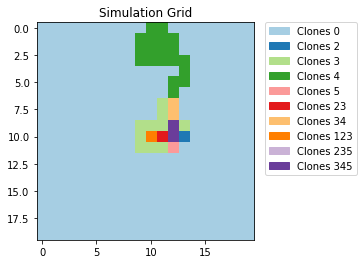

In [18]:
## global variables 
NORMAL_PURITY_THRESHOLD=.20
N = 20
phylogeny = {
    "1": [2, 3],
    "2": [],
    "3": [4, 5],
    "4": [],
    "5": []
}
root = get_root(phylogeny)
num_clones = len(phylogeny.keys())

grid=get_grid(phylogeny, N)
img_grid = [[stringify(grid[x][y].keys()) for x in range(N)] for y in range(N)]

pretty_print(img_grid)
grid_plot=plot_grid(grid)

## Generate matrix U and F
* `u` is the clonal prevalence matrix
* `f` is the frequency matrix

In [19]:
def construct_u(grid):
    U = [[0 for x in range(len(phylogeny))] for y in range(N*N)]
    for r in range(len(grid)):
        for c in range(len(grid[0])):
            for key in grid[r][c]:
                # ignore normal for matrix F 
                if key != '0':
                    # f_col stands for the clone 
                    f_col=int(key)-1
                    # number of columns * x + y 
                    f_row=r + N*c
                    U[f_row][f_col] = grid[r][c][key]
    return U
                

In [20]:
def get_f(tree, u):
    F = [row[:] for row in u]
    root = get_root(tree)
    
    def recurse(node, parent, u, temp_F):
        for child in tree[node]:          
            recurse(str(child), node, u, temp_F)
        if node != root:
            parent_idx=int(parent)-1
            node_idx=int(node)-1
            for row in range(len(temp_F)):
                temp_F[row][parent_idx] += temp_F[row][node_idx]
                
        return temp_F
    
    F = recurse(root, root, u, F)
    return F

In [21]:
matrix_u=construct_u(grid)
matrix_f=get_f(phylogeny,matrix_u)

In [26]:
## Test to make sure numbers are correct 
## (i.e., none are negative, or above 1)

def test(matrix):
    for row in matrix:
        for cell in row:
            if cell > 1 or cell < -1:
                print("Error: " + str(cell))

In [23]:
test(matrix_f)

## Enumerate 

* Use OncoLib to enumerate all possible phylogenetic trees, given the frequency matrix 
https://github.com/elkebir-group/OncoLib

In [25]:
f=matrix_f
n=len(f[0])

In [124]:
# make sure to update sample (# of biopsies/grid points) and characters (mutation clusters)

with open('enum_sim.tsv', 'w') as file:
    file.write("1 #anatomical sites\n400 #samples\n5 #characters\n")
    file.write("#sample_index\tsample_label\tanatomical_site_index\tanatomical_site_label\tcharacter_index\tcharacter_label\tf-\tf+\n")
    entry=""
    # every sample
    for row_idx, row in enumerate(f):
        x=row_idx//n
        y=row_idx%n
        coord=str(x)+"_"+str(y)
        # every mutation cluster 
        for col_idx,col in enumerate(row):
            entry+=str(row_idx)+"\t"+coord+"\t0\tNA\t"
            entry+=str(col_idx)+"\t"+str(col_idx)+"\t"+str(col)+"\t"+str(col)+"\n"

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27